In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import joblib

In [2]:
DATASET_PATH = "Emotions"

### Visualize Spectrogram

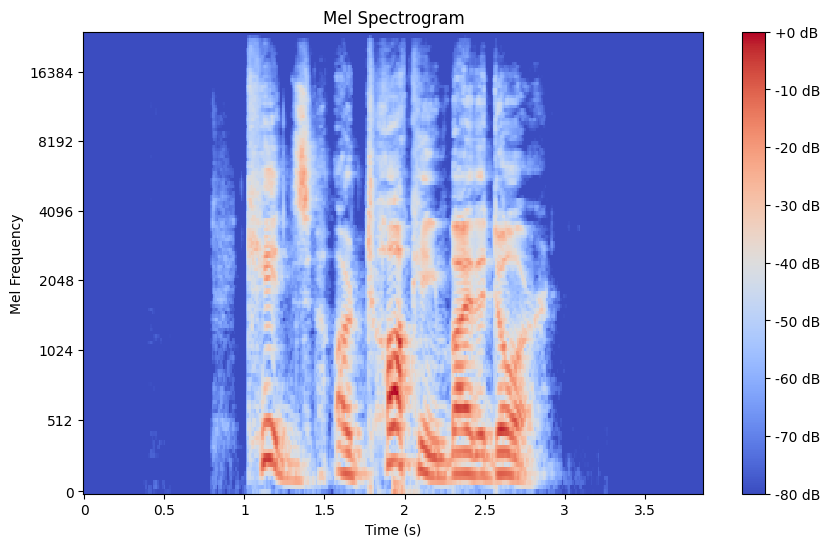

In [3]:
def visualize_spectrogram(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis="time", y_axis="mel", cmap="coolwarm")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

sample_file = os.path.join(DATASET_PATH, "Angry", os.listdir(os.path.join(DATASET_PATH, "Angry"))[0])
visualize_spectrogram(sample_file)

### Extract Features

In [4]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])

### Load Dataset and Extract Features

In [5]:
def load_data(dataset_path):
    features, labels = [], []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                try:
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(features), np.array(labels)

In [ ]:
print("Extracting features...")
X, y = load_data(DATASET_PATH)
print("Features extracted.")


### Encode Labels and Split Data

In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


### Normalize Features

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Build the Neural Network Model using TensorFlow Sequential

In [ ]:
print("Building model...")
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])


### Compile the Model

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### Train the Model

In [ ]:
print("Training model...")
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


### Evaluate the Model

In [ ]:
print("Evaluating model...")
y_pred = np.argmax(model.predict(X_test), axis=1)


### Classification Report and Confusion Matrix

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Save the Model and Preprocessing Tools

In [ ]:
model.save("aloha_emotion_classifier_model.h5")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model and preprocessing tools saved.")

### Model Usage

In [ ]:
import numpy as np
import joblib
import tensorflow as tf


model = tf.keras.models.load_model("aloha_emotion_classifier_model.h5")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])

def predict_emotion(audio_file_path):

    features = extract_features(audio_file_path)
    features = scaler.transform([features])
    predicted_class = np.argmax(model.predict(features), axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)
    return predicted_label[0]

audio_file_path = "OAF_base_neutral.wav" 
predicted_emotion = predict_emotion(audio_file_path)

print(f"The predicted emotion is: {predicted_emotion}")
